# "Пайплайн проекта"

Выбранный датасет: Online Shoppers Purchasing Intention Dataset

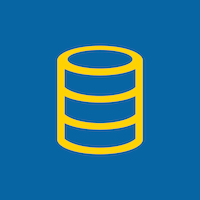

# 0. Baseline-решение и определение лучших моделей

## Импорт библиотек

В этом шаге быстро пробежимся по нашим данным ещё раз и заполним пропуски, которые мы определили в части EDA.




In [ ]:
!pip install catboost -q
!pip install explainerdashboard -q
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.8/287.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score, roc_auc_score

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool

from IPython.display import clear_output
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from IPython.core.interactiveshell import InteractiveShell

from typing import Tuple

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(42)
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# результаты всех моделей во время обучения
results = []

In [ ]:
# Подзагрузка датасета Shoppers
SHOPPERS_DATASET = 'https://raw.githubusercontent.com/metanovus/ai_edu_repo/main/online_shoppers_intention.csv'

In [ ]:
df = pd.read_csv(SHOPPERS_DATASET)

## Рассмотрение данных


*   `Administrative`, `Informational`, `Product Related` - различные типы страниц, посещённые посетителями;

*   `Administrative Duration`, `Informational Duration`, `Product Related Duration` - общее время, проведенное на каждой из этих категорий страниц;

* `Special Day` - указывает на близость времени посещения сайта к определенному особому дню (например, Дню матери, Дню святого Валентина), в который сеансы с большей вероятностью завершатся транзакцией;

* `Operating Systems` - тип операционный системы (целое число);

* `Region` - код региона;

* `Traffic Type` - тип траффика;

* `Visitor Type` - категория посетителя (постоянный, новичок или прочее);

* `Weekend` - булево значение, указывающее на выходной день;

* `Revenue` - булево значение, указывающее на то, что был получен доход (целевая переменная).

Показатели, измеренные Google Analytics для каждой страницы сайта электронной торговли:

* `Bounce Rate` - расчет количества отказов по отношению к общему количеству просмотров страницы;

* `Exit Rate` - определяется числом людей, покинувших сайт после перехода на страницу, и сравнивается с общим количеством просмотров, полученных страницей;

* `Page Value` - среднее значение страницы, которую посетил пользователь перед тем, как перейти на целевую страницу или завершить транзакцию электронной торговли (или и то, и другое).

Решаем задачу классификации, целевой признак - `Revenue` (True, False) - совершит пользователь целевой действие на сайте (а именно покупку) или нет.

In [ ]:
# Пример данных (первые 5 значений датасета)
df.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
# взглянем ещё раз на типы данных в нашем датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12131 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  11839 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12231 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [ ]:
df['Revenue'].value_counts()

Revenue
False    10422
True      1908
Name: count, dtype: int64

У нас присутствует крайне сильный дисбаланс классов (90% - отрицательные классы и 10% - положительные). Скорее всего, наша модель просто может поставить отрицательные классы всем строчкам, и метрика покажет высокое качество, что не будет иметь никакой ценности на практике, если наша модель столкнётся с большим количеством признаков, при которых класс должен быть положительный. Наша модель однозначно переобучится. Возможно, в реальных условиях понадобилась процедура Boostrap или способы пересэмплирования, но этим здесь заниматься не будем.

Так как у нас есть категориальные признаки тоже, то в дальнейшем мы их закодируем. Для начала определим лучшие модели, затем обучим модель только на числовых, подберём гиперпараметры. Затем вернём категориальные признаки, закодируем их, подберём гиперпараметры и обучим новую модель. Далее попытаемся улучшить метрику.

По части EDA мы обнаружили столбцы, имеющие пропуски:

*   Столбец "Informational Duration" имеет около 1.6% пропусков;
*   Столбец "Product Related Duration" имеет около 4% пропусков;
*   Столбец "ExitRates" имеет около 0.8% пропусков.

In [ ]:
# Так как у нас везде пустых значений менее 5%, то заполним пропуски медианным значением.
median_inf_duration = df['Informational_Duration'].median()
median_prod_rel_duration = df['ProductRelated_Duration'].median()
median_exit_rates = df['ExitRates'].median()

df['Informational_Duration'].fillna(median_inf_duration, inplace=True)
df['ProductRelated_Duration'].fillna(median_prod_rel_duration, inplace=True)
df['ExitRates'].fillna(median_exit_rates, inplace=True)

## Baseline-решение

Функцию ниже будет использовать для обучения многих известных моделей классификации, включая "Наивный Байес", и узнаем, какая модель добьётся наилучших показателей.

In [ ]:
# функция для составления baseline-решения с K-Fold-валидацией
def train_baseline_models(algorithm: str,
                         X: pd.core.frame.DataFrame,
                         y: pd.core.series.Series,
                         encoder: str = None,
                         scaler: str = None) -> Tuple[float, float]:
    '''
    Main function for training of many standart sklearn models

    algorithm: name of sklearn algorithm
    X: matrix of features
    y: vector of target variable
    encoder: string type of Encoder (example: 'OrdinalEncoder')
    scaler: string type of Scaler (example: 'MinMaxScaler')
    '''

    f1_scores = []
    roc_auc_scores = []

    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        if encoder and scaler:
            X_train, X_val = encoder_scaler(X_train, X_val, y_train, encoder, scaler)

        cat_cols = [i for i, dtype in enumerate(X_train.dtypes) if dtype == 'object']

        if algorithm == 'GaussianNB':
            model = GaussianNB().fit(X_train, y_train)

        elif algorithm == 'LogisticRegression':
            model = LogisticRegression(random_state=RANDOM_STATE).fit(X_train, y_train)

        elif algorithm == 'KNeighborsClassifier':
            model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

        elif algorithm == 'SGDClassifier':
            model = SGDClassifier(max_iter=5000, tol=1e-3, loss='log_loss').fit(X_train, y_train)

        elif algorithm == 'RandomForestClassifier':
            model = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)

        elif algorithm == 'GradientBoostingClassifier':
            model = GradientBoostingClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)

        elif algorithm == 'CatBoostClassifier':
            train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
            eval_data = Pool(data=X_val, label=y_val, cat_features=cat_cols)

            model = CatBoostClassifier(verbose=0,
                                       cat_features=cat_cols,
                                       random_state=RANDOM_STATE)

            model.fit(train_data, eval_set=eval_data)

            f1 = f1_score(y_val, model.predict(X_val))
            f1_scores.append(f1)

            roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
            roc_auc_scores.append(roc_auc)

            return np.round(np.mean(f1_scores), 7), np.round(np.mean(roc_auc_scores), 7)

        else:
            break

        f1 = f1_score(y_val, model.predict(X_val))
        f1_scores.append(f1)

        roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
        roc_auc_scores.append(roc_auc)

    return np.round(np.mean(f1_scores), 7), np.round(np.mean(roc_auc_scores), 7)

Так как у нас есть два категориальных признака: `VisitorType` и `Month`, то мы для начала закодируем их. В качестве кодировщиков возьмём несколько типов кодировки: `OrdinalEncoder`, `TargetEncoder` и `LeaveOneOutEncoder`. Для масштабирования данных используем следующие инструменты: `MinMaxScaler`, `StandardScaler` и `RobustScaler`.

In [ ]:
def encoder_scaler(X_train: pd.core.frame.DataFrame,
                   X_test: pd.core.frame.DataFrame,
                   y_train: pd.core.series.Series,
                   encoder: str,
                   scaler: str) -> Tuple[pd.core.frame.DataFrame, pd.core.frame.DataFrame]:
    '''
    Function of transforming the train and test dataframes
    algorithm: name of sklearn algorithm
    X_train: train matrix dataset
    X_test: test matrix dataset
    y_train: train vector of target variable
    encoder: string type of Encoder (example: 'OrdinalEncoder')
    scaler: string type of Scaler (example: 'MinMaxScaler')
    '''

    cat_cols = X_train.columns[X_train.dtypes == 'object']

    encoders = {'OrdinalEncoder': OrdinalEncoder(cols=cat_cols),
                'TargetEncoder': TargetEncoder(cols=cat_cols),
                'LeaveOneOutEncoder': LeaveOneOutEncoder(cols=cat_cols)}

    scalers = {'MinMaxScaler': MinMaxScaler(),
               'StandardScaler': StandardScaler(),
               'RobustScaler': RobustScaler()}

    transformer = Pipeline([
       ('encoder_', encoders[encoder]),
       ('scaler_', scalers[scaler])
       ])

    X_train_transformed = pd.DataFrame(transformer.fit_transform(X_train, y_train),
                                       columns=transformer.named_steps['encoder_']
                                       .get_feature_names_out())

    X_test_transformed = pd.DataFrame(transformer.transform(X_test),
                                      columns=transformer.named_steps['encoder_']
                                      .get_feature_names_out())

    return X_train_transformed, X_test_transformed

In [ ]:
# функция для выполнения первичного baseline предсказания
def make_baseline_prediction(X: pd.core.frame.DataFrame, y: pd.core.series.Series) -> None:
    '''
    Function of BaseLine-making
    X: matrix of features
    y: vector of target variable
    '''
    models = ['GaussianNB',
              'SGDClassifier',
              'RandomForestClassifier',
              'GradientBoostingClassifier',
              'CatBoostClassifier',
              'LogisticRegression',
              'KNeighborsClassifier']
    encoders = ['OrdinalEncoder', 'TargetEncoder', 'LeaveOneOutEncoder']
    scalers = ['MinMaxScaler', 'StandardScaler', 'RobustScaler']

    for model in tqdm(models):
        for encoder in encoders:
            for scaler in scalers:
                F1_score, ROC_AUC_score = train_baseline_models(model, X, y, encoder, scaler)
                results.append({'model': model,
                                'encoder': encoder,
                                'scaler': scaler,
                                'F1_score': F1_score,
                                'ROC_AUC_Score': ROC_AUC_score,
                                'comment': 'Baseline-решение'})

    F1_score, ROC_AUC_score = train_baseline_models('CatBoostClassifier', X, y)
    results.append({'model': 'CatBoostClassifier',
                    'encoder': None,
                    'scaler': None,
                    'F1_score': F1_score,
                    'ROC_AUC_Score': ROC_AUC_score,
                    'comment': 'Baseline-решение'})

Разделим наши данные на объект матрицу-признак _X_ и вектор целевой переменной _y_. Затем построим baseline-решения (множество моделей) с различными кодировщиками и масштабировщиками и посмотрим на предварительные результаты. К прочим sklearn-моделям мы припишем модель градиентного бустинга CatBoostClassifier, которая очень часто показывает хорошие результаты обучения.

Для точности будем обучать модели по кросс-валидации (на 5 фолдов).

In [ ]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

make_baseline_prediction(X, y)

100%|██████████| 7/7 [03:10<00:00, 27.28s/it]


In [ ]:
pd.DataFrame(results).sort_values(by='F1_score', ascending=False).iloc[:5]

,model,encoder,scaler,F1_score,ROC_AUC_Score,comment
30,GradientBoostingClassifier,TargetEncoder,MinMaxScaler,0.655462,0.929489,Baseline-решение
32,GradientBoostingClassifier,TargetEncoder,RobustScaler,0.655268,0.929483,Baseline-решение
31,GradientBoostingClassifier,TargetEncoder,StandardScaler,0.655268,0.929490,Baseline-решение
27,GradientBoostingClassifier,OrdinalEncoder,MinMaxScaler,0.647002,0.929211,Baseline-решение
29,GradientBoostingClassifier,OrdinalEncoder,RobustScaler,0.647002,0.929215,Baseline-решение


In [ ]:
pd.DataFrame(results).sort_values(by='ROC_AUC_Score', ascending=False).iloc[:5]

,model,encoder,scaler,F1_score,ROC_AUC_Score,comment
38,CatBoostClassifier,OrdinalEncoder,RobustScaler,0.644272,0.931292,Baseline-решение
37,CatBoostClassifier,OrdinalEncoder,StandardScaler,0.644272,0.931292,Baseline-решение
36,CatBoostClassifier,OrdinalEncoder,MinMaxScaler,0.644272,0.931292,Baseline-решение
63,CatBoostClassifier,None,None,0.643103,0.930069,Baseline-решение
39,CatBoostClassifier,TargetEncoder,MinMaxScaler,0.644214,0.929579,Baseline-решение


Что имеем:
* `CatBoostClassifier` показал себя лучше, по метрике `F1` с `TargetEncoder` и `RobustScaler`: 0.655462;
* `GradientBoostingClassifier` отработал лучше, если судить по метрике `ROC-AUC` с `OrdinalEncoder` и `RobustScaler`: 0.931292

Чтобы не выполнять лишнюю работу и в дальнейшем без проблем можно было сделать стекинг моделей для лучшего качества и подобрать порог для определения класса (`threshold`), выберем эти две модели с одинаковыми инструментами обработки данных - `TargetEncoder` и `RobustScaler`, а метрику возьмём `F1`.

Сразу напишем две функции для обучения модели `CatBoostClassifier` и `GradientBoostingClassifier`.

In [ ]:
def catboost_classifier_train(X_train: pd.core.frame.DataFrame,
                              X_val: pd.core.frame.DataFrame,
                              y_train: pd.core.series.Series,
                              y_val: pd.core.series.Series,
                              X_test: pd.core.frame.DataFrame,
                              y_test: pd.core.series.Series,
                              init_params: dict = {}) -> Tuple[CatBoostClassifier, float]:
    '''
    Main function for CatBoostClassifier model training

    X_train: train matrix of features
    X_val: validate matrix of features
    y_train: train vector of target variable
    y_val: validate vector of target variable
    X_test: test matrix of features
    y_test: test vector of target variable
    init_params: params for training model
    '''
    train_data = Pool(data=X_train, label=y_train)
    eval_data = Pool(data=X_val, label=y_val)

    model = CatBoostClassifier(verbose=250,
                               random_state=RANDOM_STATE,
                               **init_params)

    model.fit(train_data, eval_set=eval_data)

    y_pred = model.predict(X_test)
    return model, f1_score(y_test, y_pred)

In [ ]:
def gradboost_classifier_train(X_train: pd.core.frame.DataFrame,
                               X_val: pd.core.frame.DataFrame,
                               y_train: pd.core.series.Series,
                               y_val: pd.core.series.Series,
                               init_params: dict = {}) -> Tuple[GradientBoostingClassifier, float]:
    '''
    Main function for GradientBoostingClassifier model training

    X_train: train matrix of features
    X_val: validate matrix of features
    y_train: train vector of target variable
    y_val: validate vector of target variable
    init_params: params for training model
    '''
    model = GradientBoostingClassifier(**init_params,
                                       random_state=RANDOM_STATE)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    return model, f1_score(y_val, y_pred)

# 1. Обучение моделей на числовых признаках



Ещё раз выделим нашу матрицу объект-признак с вектором целевой переменной и обучим наши две модели на числовых признаках.

In [ ]:
num_cols = [col for col in X.columns if X[col].dtype != object]
X = df[num_cols]
y = df['Revenue']

In [ ]:
# тренировка моделей на числовых признаках

cb_num_f1, cb_num_roc_auc = train_baseline_models('CatBoostClassifier', X, y, 'TargetEncoder', 'RobustScaler')
gb_num_f1, gb_num_roc_auc = train_baseline_models('GradientBoostingClassifier', X, y, 'TargetEncoder', 'RobustScaler')

In [ ]:
results.append({'model': 'CatBoostClassifier',
                'encoder':'TargetEncoder',
                'scaler': 'RobustScaler',
                'F1_score': cb_num_f1,
                'ROC_AUC_Score': None,
                'comment': 'Числовые признаки без подбора параметров'})

results.append({'model':'GradientBoostingClassifier',
                'encoder': 'TargetEncoder',
                'scaler': 'RobustScaler',
                'F1_score': gb_num_f1,
                'ROC_AUC_Score': None,
                'comment': 'Числовые признаки без подбора параметров'})

# 2. Подбор гиперпараметров у каждой из моделей при помощи кросс-валидации

Ещё раз зададим подготовим наши данные с помощью лучших инструментов масштабирования и кодирования категориальных признаков для каждой из моделей соответственно. Выберем так же валидационные и тестовые данные, вторые используем только для измерения финального качества модели.

Предобработаем все наши данные и запустим после этого цикл подбора гиперпараметров.

In [ ]:
def grid_search_cv(X: pd.core.frame.DataFrame,
                   y: pd.core.series.Series,
                   model_name: str,
                   num_folds: int = 3) -> Tuple[float, dict[str | float]]:
    '''
    Function of CV-tuning of hyperparameters (similar to GridSearchCV)
    X: matrix of features
    y: vector of target variable
    model_name: name of alghoritm (example: 'LogisticRegression')
    num_folds: how many folds to take to split
    '''
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=RANDOM_STATE)

    f1_best = 0
    params_best = {}

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        cat_cols = X_train.columns[X_train.dtypes == 'object']

        pipeline = Pipeline([
            ('encoder', TargetEncoder(cols=cat_cols)),
            ('scaler', RobustScaler())]).fit(X_train, y_train)

        X_train = pipeline.transform(X_train)
        X_val = pipeline.transform(X_val)

        if model_name == 'GradientBoostingClassifier':

            param_grid_gbc = {
                'learning_rate': [0.01, 0.1, 0.5],
                'max_depth': [3, 5, 7],
                'n_estimators': [50, 100, 200]}

            for lr in param_grid_gbc['learning_rate']:
                for md in param_grid_gbc['max_depth']:
                    for ne in param_grid_gbc['n_estimators']:

                        params = {'learning_rate': lr,
                                  'max_depth': md,
                                  'n_estimators': ne}

                        model = GradientBoostingClassifier(**params, random_state=RANDOM_STATE)
                        model.fit(X_train, y_train)

                        f1 = f1_score(y_val, model.predict(X_val))

                        if f1 > f1_best:
                            f1_best = f1
                            params_best = params

        elif model_name == 'CatBoostClassifier':
            param_grid_cb = {
                'learning_rate': [0.01, 0.1, 0.5],
                'depth': [4, 6, 8],
                'iterations': [100, 500, 1000]}

            for lr in param_grid_cb['learning_rate']:
                for d in param_grid_cb['depth']:
                    for iter in param_grid_cb['iterations']:
                        train_data = Pool(data=X_train, label=y_train)
                        test_data = Pool(data=X_val, label=y_val)

                        params = {'learning_rate': lr,
                                  'depth': d,
                                  'iterations': iter}

                        model = CatBoostClassifier(verbose=0,
                                                   random_state=RANDOM_STATE,
                                                   **params)

                        model.fit(train_data,
                                  eval_set=test_data)

                        f1 = f1_score(y_val, model.predict(X_val))

                        if f1 > f1_best:
                            f1_best = f1
                            params_best = params

    return f1_best, params_best

In [ ]:
cb_num_f1, cb_num_best_params = grid_search_cv(X, y, 'CatBoostClassifier')
gb_num_f1, gb_num_best_params = grid_search_cv(X, y, 'GradientBoostingClassifier')

Взглянем на результаты подбора гиперпараметров для наших двух моделей.

In [ ]:
print(f'CatBoostClassifier: {cb_num_f1:.4f} with params: {cb_num_best_params}')
print(f'GradientBoostingClassifier: {gb_num_f1:.4f} with params: {gb_num_best_params}')

CatBoostClassifier: 0.6518 with params: {'learning_rate': 0.1, 'depth': 4, 'iterations': 100}
GradientBoostingClassifier: 0.6409 with params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


Имеем значение `F1 Score`, равный 0.65 для модели `CatBoostClassifier` при следующих параметрах:
```python
{'learning_rate': 0.1, 'depth': 4, 'iterations': 500}
```

Имеем значение `F1 Score`, равный 0.64 для модели `GradientBoostingClassifier` при следующих параметрах:
```python
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
```

In [ ]:
results.append({'model': 'CatBoostClassifier',
                'encoder': 'TargetEncoder',
                'scaler': 'RobustScaler',
                'F1_score': cb_num_f1 ,
                'ROC_AUC_Score': None,
                'comment':'Числовые признаки с подбором параметров'})

results.append({'model': 'GradientBoostingClassifier',
                'encoder': 'TargetEncoder',
                'scaler': 'RobustScaler',
                'F1_score':gb_num_f1,
                'ROC_AUC_Score':None,
                'comment':'Числовые признаки с подбором параметров'})

# 3. Добавление категориальных признаков

Так как мы в первой части задания мы уже обучили модели по кросс-валидации с категориальными признаками и определили оптимальный кодировщик (`TargetEncoder`), то в этой части мы подберём гиперпараметры по кросс-валидации по всем признакам.

In [ ]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [ ]:
cb_full_f1, cb_full_best_params = grid_search_cv(X, y, 'CatBoostClassifier')
gb_full_f1, gb_full_best_params = grid_search_cv(X, y, 'GradientBoostingClassifier')

In [ ]:
print(f'CatBoostClassifier: {cb_full_f1:.4f} with params: {cb_full_best_params}')
print(f'GradientBoostingClassifier: {gb_full_f1:.4f} with params: {gb_full_best_params}')

CatBoostClassifier: 0.6667 with params: {'learning_rate': 0.1, 'depth': 4, 'iterations': 100}
GradientBoostingClassifier: 0.6655 with params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


Имеем значение `F1 Score`, равное 0.66 для модели `CatBoostClassifier` при следующих параметрах:
```python
{'learning_rate': 0.5, 'depth': 4, 'iterations': 100}
```

Имеем значение `F1 Score`, равное 0.66 для модели `GradientBoostingClassifier` при следующих параметрах:
```python
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
```

In [ ]:
results.append({'model': 'CatBoostClassifier',
                'encoder': 'TargetEncoder',
                'scaler': 'RobustScaler',
                'F1_score': cb_full_f1,
                'ROC_AUC_Score': None,
                'comment': 'Все признаки с подбором параметров'})

results.append({'model': 'GradientBoostingClassifier',
                'encoder': 'TargetEncoder',
                'scaler': 'RobustScaler',
                'F1_score': gb_full_f1,
                'ROC_AUC_Score': None,
                'comment': 'Все признаки с подбором параметров'})

В качестве модели для построения дашборда возьмём `CatBoostClassifier`.

In [ ]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=RANDOM_STATE)

cat_cols = X_train.columns[X_train.dtypes == 'object']

pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_cols)),
    ('scaler', RobustScaler())]).fit(X_train, y_train)

X_train = pd.DataFrame(pipeline.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(pipeline.transform(X_test), columns=X_test.columns)
X_val = pd.DataFrame(pipeline.transform(X_val), columns=X_val.columns)

cb_model, cb_f1 = catboost_classifier_train(X_train, X_val,
                                        y_train, y_val,
                                        X_test, y_test,
                                        init_params=cb_full_best_params)
print(f'F1 Score: {cb_f1:.4f}')

0:	learn: 0.6267852	test: 0.6296205	best: 0.6296205 (0)	total: 2.24ms	remaining: 222ms
99:	learn: 0.2009527	test: 0.2494761	best: 0.2493676 (94)	total: 180ms	remaining: 0us

bestTest = 0.2493676284
bestIteration = 94

Shrink model to first 95 iterations.
F1 Score: 0.6527


После разделения данных на тренировочную, тестовую и валидационную часть имеем значением метрики `F1 Score` в районе 0.65, что не сильно отличается от значения метрики при кросс-валидации. Возможно, подбор`RANDOM_STATE` сможет улучшить положение.

## Подбор оптимального threshold для перевода в положительный класс

In [ ]:
train_data = Pool(data=X_train, label=y_train)
eval_data = Pool(data=X_val, label=y_val)

cb_model = CatBoostClassifier(verbose=250,
                           random_state=RANDOM_STATE,
                           **cb_full_best_params)

cb_model.fit(train_data, eval_set=eval_data)

cb_preds_test = cb_model.predict_proba(X_test)[:, 1]
cb_preds_val = cb_model.predict_proba(X_val)[:, 1]

threshold_best = 0
f1_best = 0

for threshold in np.arange(0, 1, 0.01):
    final_preds_test = np.where(cb_preds_test >= threshold, 1, 0)
    final_preds_val = np.where(cb_preds_val >= threshold, 1, 0)

    f1_test = f1_score(y_test, final_preds_test)
    f1_val = f1_score(y_val, final_preds_val)

    f1_mean = (f1_test + f1_val) / 2

    if f1_mean > f1_best:
        f1_best = f1_mean
        threshold_best = threshold

print(f'Best F1 Score: {f1_best:.4f}, best threshold: {threshold_best}')

0:	learn: 0.6267852	test: 0.6296205	best: 0.6296205 (0)	total: 3.2ms	remaining: 316ms
99:	learn: 0.2009527	test: 0.2494761	best: 0.2493676 (94)	total: 372ms	remaining: 0us

bestTest = 0.2493676284
bestIteration = 94

Shrink model to first 95 iterations.


Best F1 Score: 0.6772, best threshold: 0.31


Лучший порог для перевода в положительный класс 0.31, с ним у нас скоринг метрики `F1 Score` повышается до 0.68.

# 4. Построение ExplainerDashboard

In [ ]:
explainer = ClassifierExplainer(cb_model, X_test, y_test)

Note: model_output=='probability'. For CatBoostClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [ ]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [ ]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Анализ результатов дашборда и выводы по результатам качества моделей

### Объяснение важности признаков

* По `SHAP values`, топ-10 наиболее важных следующих признаков: `PageValues` (самый важный признак), `Month`, `BounceRates`, `ExitRates`, `ProductRelated`, `VisitorType`, `Administrative`, `Region`, `ProductRelated_Duration`, `TrafficType`;
* По `Permutation Importances`, наиболее важны признаки: `PageValues` (так же самый важный признак), `Month`, `ProductRelated_Duration`, `ProductRelated`, `ExitRates`.

### Получившиеся метрики в дашборде

При подобранном пороге разделения классов в 0.31 имеем следующие значения метрик:

* `Accuracy`: 0.894;
* `Precision`: 0.64;
* `Recall`: 0.751;
* `F1 Score`: 0.691;
* `ROC-AUC Score`: 0.93;
* `PR-AUC Score`: 0.749;
* `Log Loss`: 0.236.

ROC-AUC Curve:

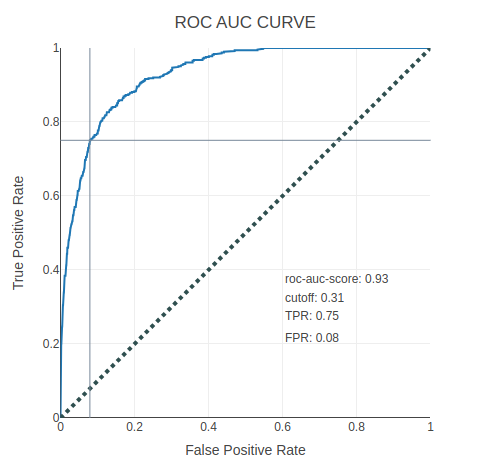

Confusion Matrix:

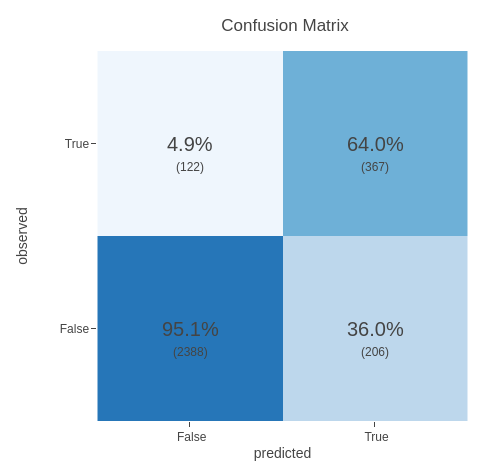

Выводы по Confusion Matrix:
* Как и следовало ожидать, наша модель переобучилась на отрицательных классах, которых в исходном датасете около 90%, показатель истинноотрицательных (TN) составил аж 95%;
* Показатель истинноположительных (TP) составил 64%, что по сравнению с TN является довольно низким показателем;
* Ложноотрицательных ответов (FN) у нас вышло аж 36%, что так же подтверждает то, что наша модель переобучилась на отрицательных классах;
* Ложноположительных у нас крайне мало (FP), но это и ясно, наша модель, можно сказать, училась видеть лишь отрицательные классы, и конкретно с этой задачей она справилась отлично, что нельзя сказать о поиске положительных классов.

Выводы по метрикам:

* `Precision` у нас вышел 0.64, то есть доля положительных ответов правильных из всех ответов составила 64%, что так же видно и в Confusion Matrix;
* Значение метрики `Recall` составило 0.751, то есть 75,1% ответов у нас правильные, но опять же это во многом из-за того, что наша модель научилась определять отрицательные классы (их у нас 90% в датасете), это никак не говорит о том, что наша модель хорошая;
* `ROC-AUC` составил 0.93, то есть наша модель с точность до 93% различает отрицательные и положительные классы, здесь опять же сказывается баланс классов, низкий показатель `Recall` говорит об обратном;
* `Log loss` и `Accuracy` говорят о том, что наша модель хорошо откалибрована и о том, что модель хорошо предсказывает ответы.

## Анализ индивидуальных прогнозов

1. Рассмотрим один из объектов из множества ложноотрицательных классов:

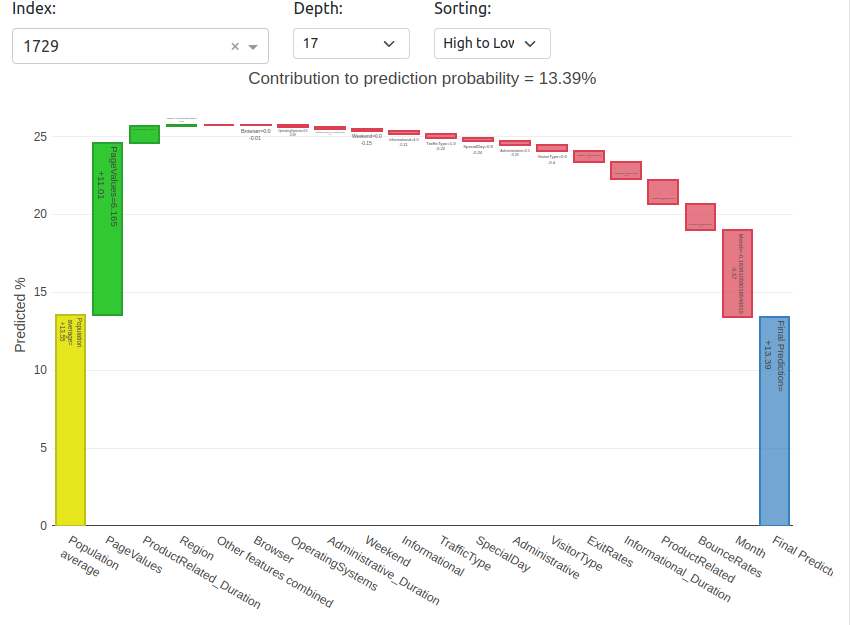

> Объект с индексом 1729 был предсказан, как отрицательный с вероятность аж почти 87%, по графику видно, что признаки `Population Average` и `PageValues` (самый важный признак в среднем по `SHAP Values` и `Permutation Importance`) сначала уверенно вывели его в сторону положительного класса, но не достаточно сильно. Не считая трёх признаков, остальные достаточно уверенно вывели его в сторону отрицательного класса. Опять же, это может говорить о том, что наша модель переобучилась на отрицательных классах, если истинно положительный класс модель с уверенностью 87% предсказывает, как отрицательный класс.

2. Рассмотрим один из объектов из множества истинноположительных классов

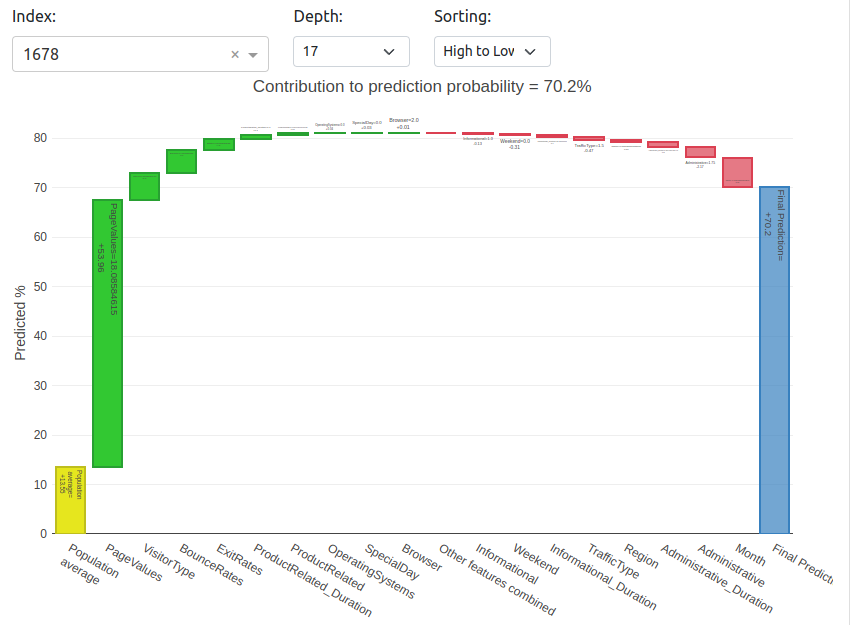

> Здесь видно, что модель положительный класс не с такой сильной уверенностью предсказывает положительный класс, как даже ложноотрицательный (70% против 87%). Опять же важные признаки для принятия правильного решения: `Population Average` и `PageValues`.

3. Теперь рассмотрим объект из множества ложноположительных классов

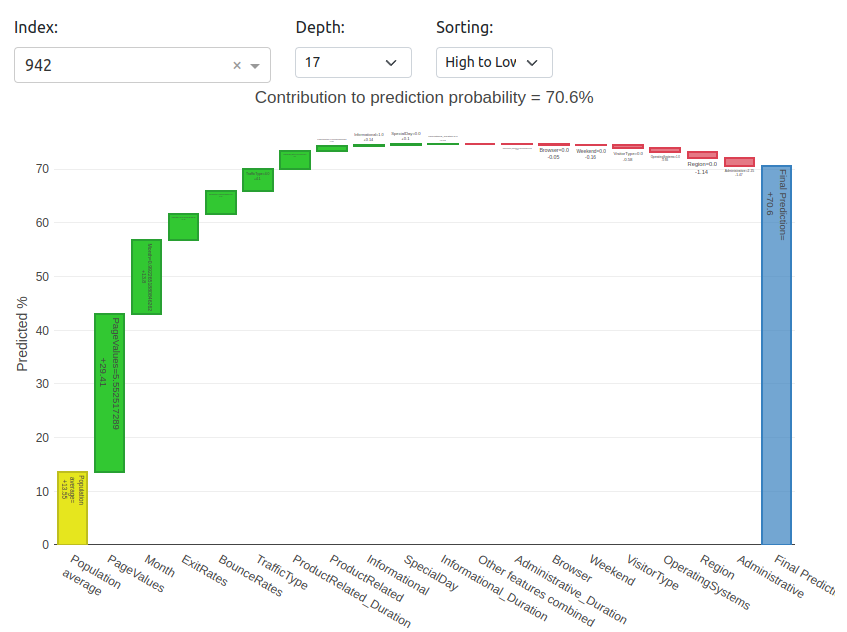

> Довольно странно видеть у модели, которая переобучилась на отрицательных классах, находить ложноположительные классы. Возможно, это благодаря алгоритмам обучения модели `CatBoosClassifier` с разделением датасета на три выборки, потому как у нас сниженная вероятность сильно переобучиться. Здесь модель ориентировалась так же на сильные признаки `Population Average` и `PageValues` (прирост в 32%). Остальные 6 признаков (`Month`, `ExitRates`, `BounceRates` и др.) окончательно вывели наш объект в множество ложноположительных классов. Чтобы решить проблему неправильного лейблинга, необходимо детально поработать с признаками.

# Остальные выводы

In [ ]:
# подгрузка всех результатов обучений множества моделей
df_results = pd.DataFrame(results)

С помощью простого подбора порога вероятности положительного класса удалось повысить скоринг метрики `F1 Score` с 0.65 до почти 0.68. Чтобы дальше улучшать скоринг, нужно подбирать параметры через Optuna и углублённо заниматься Feature Engineering (отсеивать признаки, комбинировать и создавать новые из имеющихся). В контексте соревновательного Data Science может пригодится псевдолейбелинг, стекинг и semi-supervised learning.

Основная проблема нашей модели - очень сильный дисбаланс классов (90% отрицательных и 10% - положительных). Наши модели безупречно находят отрицательные классы, о чём лишь говорит значение TF, равное аж 95%, но с положительными классами дела обстоят куда хуже, значение TN лишь 64%. О переобучении нашей модели на отрицательных классах так же говорит низкое значение порога перевода класса в положительный (лишь 0.31), это говорит о том, что наша модель крайн неуверенно переводит класс объекта в положительный, а при значении порога 0.5 гипотетически практически все объекты обретут отрицательный класс.

In [ ]:
display(df_results[df_results['model'] == 'SGDClassifier'].sort_values(by=['F1_score', 'ROC_AUC_Score'], ascending=False)[:1])
display(df_results[df_results['model'] == 'GaussianNB'].sort_values(by=['F1_score', 'ROC_AUC_Score'], ascending=False)[:1])
display(df_results[df_results['model'] == 'LogisticRegression'].sort_values(by=['F1_score', 'ROC_AUC_Score'], ascending=False)[:1])
display(df_results[df_results['model'] == 'KNeighborsClassifier'].sort_values(by=['F1_score', 'ROC_AUC_Score'], ascending=False)[:1])

,model,encoder,scaler,F1_score,ROC_AUC_Score,comment
11,SGDClassifier,OrdinalEncoder,RobustScaler,0.542133,0.713767,Baseline-решение


,model,encoder,scaler,F1_score,ROC_AUC_Score,comment
2,GaussianNB,OrdinalEncoder,RobustScaler,0.521485,0.829338,Baseline-решение


,model,encoder,scaler,F1_score,ROC_AUC_Score,comment
50,LogisticRegression,TargetEncoder,RobustScaler,0.504389,0.894097,Baseline-решение


,model,encoder,scaler,F1_score,ROC_AUC_Score,comment
59,KNeighborsClassifier,TargetEncoder,RobustScaler,0.559259,0.819389,Baseline-решение


Что касается простейших моделей (`SGDClassifier`, `GaussianNB`, `LogisticRegression`, `KNeighborsClassifier`), то они отработали хуже всех, однако метод ближайших соседей (`KNeighborsClassifier`) показал себя лучше всех по метрике `F1 Score`, а логистическая регрессия (`LogisticRegression`) лучше всех показала себя по метрике `ROC-AUC`. Поэтому для быстроты прогноза и быстрого пересчёта алгоритмов объяснения важности признаков (например, `SHAP values`, `Permutation Importances`) есть смысл использовать данные алгоритмы.